In [1]:
!pip install --upgrade batchgenerators

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.4/96.4 kB 6.2 MB/s eta 0:00:00
  Created wheel for batchgenerators: filename=batchgenerators-0.25-py3-none-any.whl size=89007 sha256=c366e409517da7a38562dd65186d67bf1b7ff1b7d12830b6bb08581c37784bb8
  Stored in directory: /root/.cache/pip/wheels/9e/b0/1b/40912fb58eb167b86cbc444ddb2e6ba382b248215295f932e2
Successfully built batchgenerators


In [1]:
!pip install segmentation-models-pytorch
!pip install mistune
!pip install opencv-python
!pip install torch
!pip install torch-summary
!pip install torchaudio
!pip install torchsummary
!pip install torchvision
!pip install wandb
!pip install tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.3/277.3 kB 36.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.6 MB/s eta 0:00:00


In [2]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
import utils
import metric
import torch
import dataloader
from batchgenerators.dataloading.multi_threaded_augmenter import MultiThreadedAugmenter
import segmentation_models_pytorch as smp
from torchsummary import summary
import time
import math
import pandas as pd
import wandb
from tqdm import tqdm
from torch import nn
from sklearn.metrics import precision_recall_fscore_support, jaccard_score
from scipy.spatial.distance import directed_hausdorff
from matplotlib.lines import Line2D
import seaborn as sns
%matplotlib inline

/content/utils.py:91: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if mask.ndim is 3:
/content/utils.py:113: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if mask.ndim is 3:


#Hyperparameters


In [3]:
# load hyperparams
batch_size = 16
patch_size = (512, 512)#512, 512
encoder_model = 'resnet18'
n_class = 1
test_fol = 'Metaplasia_ds'
weight_path = '/content/drive/MyDrive/Mauricio Caviedes/Code/Gland-Segmentation-main/weights/best_weight.pth'

#Model Building

In [4]:
warnings.filterwarnings('ignore')
#tabular_data = pd.read_csv('/content/drive/MyDrive/Mauricio Caviedes/Code/Gland-Segmentation-main/data.csv')
tabular_data = pd.read_csv('/content/data.csv')

ds_dict = dataloader.get_split_fold(tabular_data)
val_dl = dataloader.DataLoader(data=ds_dict[test_fol], batch_size=batch_size, patch_size=patch_size,
                               num_threads_in_multithreaded=1, seed_for_shuffle=5243,
                               return_incomplete=True, shuffle=False, infinite=False)
# Get cpu or gpu device for training
device = "cuda" if torch.cuda.is_available() else "cpu"
# define model
model = smp.Unet(encoder_name=encoder_model, decoder_use_batchnorm=True,
                 in_channels=3, classes=n_class).to(device)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 298MB/s]


In [5]:
summary(model, (3, 512, 512)) #512 , 512

Layer (type:depth-idx)                   Output Shape              Param #
├─ResNetEncoder: 1-1                     [-1, 3, 512, 512]         --
|    └─Conv2d: 2-1                       [-1, 64, 256, 256]        9,408
|    └─BatchNorm2d: 2-2                  [-1, 64, 256, 256]        128
|    └─ReLU: 2-3                         [-1, 64, 256, 256]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 128, 128]        --
|    └─Sequential: 2-5                   [-1, 64, 128, 128]        --
|    |    └─BasicBlock: 3-1              [-1, 64, 128, 128]        73,984
|    |    └─BasicBlock: 3-2              [-1, 64, 128, 128]        73,984
|    └─Sequential: 2-6                   [-1, 128, 64, 64]         --
|    |    └─BasicBlock: 3-3              [-1, 128, 64, 64]         230,144
|    |    └─BasicBlock: 3-4              [-1, 128, 64, 64]         295,424
|    └─Sequential: 2-7                   [-1, 256, 32, 32]         --
|    |    └─BasicBlock: 3-5              [-1, 256, 32, 32]     

Layer (type:depth-idx)                   Output Shape              Param #
├─ResNetEncoder: 1-1                     [-1, 3, 512, 512]         --
|    └─Conv2d: 2-1                       [-1, 64, 256, 256]        9,408
|    └─BatchNorm2d: 2-2                  [-1, 64, 256, 256]        128
|    └─ReLU: 2-3                         [-1, 64, 256, 256]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 128, 128]        --
|    └─Sequential: 2-5                   [-1, 64, 128, 128]        --
|    |    └─BasicBlock: 3-1              [-1, 64, 128, 128]        73,984
|    |    └─BasicBlock: 3-2              [-1, 64, 128, 128]        73,984
|    └─Sequential: 2-6                   [-1, 128, 64, 64]         --
|    |    └─BasicBlock: 3-3              [-1, 128, 64, 64]         230,144
|    |    └─BasicBlock: 3-4              [-1, 128, 64, 64]         295,424
|    └─Sequential: 2-7                   [-1, 256, 32, 32]         --
|    |    └─BasicBlock: 3-5              [-1, 256, 32, 32]     

#Validation

In [6]:
# xent = nn.BCELoss()
dice_loss = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)
# label smoothing
xent = smp.losses.SoftBCEWithLogitsLoss(smooth_factor=0.1)

def custom_loss(pred, target):
    xent_l = xent(pred, target)
    dice_l = dice_loss(pred, target)
    loss = xent_l + dice_l
    return loss, xent_l, dice_l

def test(model):
    num_batches = math.ceil(len(ds_dict[test_fol]['img_npy']) / batch_size)
    print(ds_dict[test_fol]['img_npy'])
    model.eval()
    test_loss, correct = 0, 0
    # no need back prop for testing set
    batch_xent_l = []
    batch_dice_l = []
    batch_loss = []
    imgs_list = []
    segs_list = []
    pred_list = []
    segs_ori_list = []
    print("Testing...", num_batches)
    with torch.no_grad():
        for i in tqdm(range(num_batches)):
            val_batch = next(val_dl)
            imgs = val_batch['data']
            segs = val_batch['seg']
            segs_ori = segs
            # normalization
            imgs = utils.min_max_norm(imgs)
            # binarisation
            segs = np.where(segs > 0., 1.0, 0.).astype('float32')
            segs = np.expand_dims(segs[:, 0, :, :], 1)
            print(segs.shape)
            #seg_data = np.expand_dims(seg_data, axis=2)  # Fix the einsum operation
            imgs, segs = torch.from_numpy(imgs).to(device), torch.from_numpy(segs).to(device)
            # Compute loss
            pred = model(imgs)
            loss, xent_l, dice_l = custom_loss(pred, segs)
            # batch losses
            batch_xent_l.append(xent_l)
            batch_dice_l.append(dice_l)
            batch_loss.append(loss)
            # accumulate outputs for each batch
            imgs_list.append(imgs.cpu().detach().numpy())
            segs_list.append(segs.cpu().detach().numpy())
            pred_list.append(pred.cpu().detach().numpy())
            segs_ori_list.append(segs_ori)
        # apply sigmoid to masking
        segs = nn.Sigmoid()(segs)
        # taking the average along the batch
        loss = torch.mean(torch.as_tensor(batch_loss)).item()
        avg_xent_l = torch.mean(torch.as_tensor(batch_xent_l)).item()
        avg_dice_l = torch.mean(torch.as_tensor(batch_dice_l)).item()
    return {'loss': loss, 'xent_l': avg_xent_l, 'dice_l': avg_dice_l,
            'imgs': imgs_list,
            'segs': segs_list,
            'pred': pred_list,
            'segs_ori': segs_ori_list
            }

#Run Model

In [ ]:
model.load_state_dict(torch.load(weight_path))
start = time.time()
test_output = test(model)
print("Runtime: {} s".format(time.time()-start))
print("Total loss: {:.2f}, BCE: {:.2f}, Dice Loss: {:2f}".format(test_output['loss'],
    test_output['xent_l'], test_output['dice_l']))

In [8]:
# channel last for image plotting
swap = (lambda x: np.einsum('bchw->bhwc', x))
repeat_channel = (lambda x: np.repeat(x, 3, axis=-1))
# stack the image along the batch axis
total_segs = swap(np.vstack(tuple(test_output['segs_ori'])))
total_imgs = swap(np.vstack(tuple(test_output['imgs'])))
total_pred = repeat_channel(swap(np.where(np.vstack(tuple(test_output['pred']))>0.5, 1.0, 0.0)))

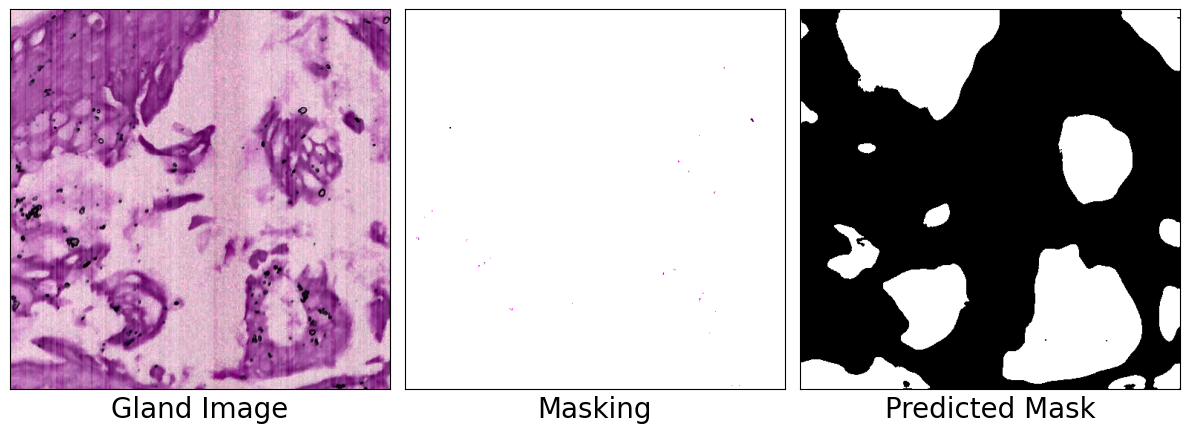

In [9]:
# sanity check for predicted output
imgs = [total_imgs[30], total_segs[30], total_pred[30]]
captions = ['Gland Image', 'Masking', 'Predicted Mask']
utils.plot_comparison(imgs, captions, n_col=len(imgs), figsize=(12, 12), cmap=None)

In [10]:
import cv2


for i in range(total_pred.shape[0]):
  cv2.imwrite(f'/content/drive/MyDrive/Mauricio Caviedes/AlcianBlue/mask/001_008_2019_ab/parche_{i}.png', total_pred[i]*255)

In [ ]:
!pip install histomicstk --find-links https://girder.github.io/large_image_wheels

In [ ]:
import cv2
import numpy as np

import girder_client
import numpy as np
from skimage.transform import resize
from matplotlib import pylab as plt
from matplotlib.colors import ListedColormap
from histomicstk.preprocessing.color_normalization import reinhard
from histomicstk.saliency.tissue_detection import (
    get_slide_thumbnail, get_tissue_mask)
from histomicstk.annotations_and_masks.annotation_and_mask_utils import (
    get_image_from_htk_response)
from histomicstk.preprocessing.color_normalization.\
    deconvolution_based_normalization import deconvolution_based_normalization
from histomicstk.preprocessing.color_deconvolution.\
    color_deconvolution import color_deconvolution_routine, stain_unmixing_routine
from histomicstk.preprocessing.augmentation.\
    color_augmentation import rgb_perturb_stain_concentration, perturb_stain_concentration

# Cargar la imagen en formato JPG
imagen_jpg = cv2.imread('001_005_2021_ab_003.jpg')



# color norm. standard (from TCGA-A2-A3XS-DX1, Amgad et al, 2019)
cnorm = {
    'mu': np.array([8.74108109, -0.12440419,  0.0444982]),
    'sigma': np.array([0.6135447, 0.10989545, 0.0286032]),
}

# TCGA-A2-A3XS-DX1_xmin21421_ymin37486_.png, Amgad et al, 2019)
# for macenco (obtained using rgb_separate_stains_macenko_pca()
# and reordered such that columns are the order:
# Hamtoxylin, Eosin, Null
W_target = np.array([
    [0.5807549,  0.08314027,  0.08213795],
    [0.71681094,  0.90081588,  0.41999816],
    [0.38588316,  0.42616716, -0.90380025],
])


tissue_rgb_normalized = reinhard(
    imagen_jpg, target_mu=cnorm['mu'], target_sigma=cnorm['sigma'])


In [ ]:
def vis_result():
    f, ax = plt.subplots(1, 2, figsize=(15, 15))
    ax[0].imshow(tissue_rgb_normalized)
    ax[1].imshow(tissue_rgb_normalized)
    plt.show()

    f, ax = plt.subplots(1, 2, figsize=(15, 15))
    ax[0].imshow(tissue_rgb_normalized[:,:,:])
    ax[1].imshow(tissue_rgb_normalized[:,:,:])
    plt.show()

vis_result()

In [ ]:
stretch_near = cv2.resize(tissue_rgb_normalized, (512, 512),
               interpolation = cv2.INTER_LINEAR)

print(stretch_near.shape)

# Guardar la imagen como un arreglo NumPy en un archivo .npy
np.save('001_005_2021_ab.npy', stretch_near)

(512, 512, 3)


# Trabajo adicionales

In [ ]:
import cv2
from skimage import io, color, filters
import numpy as np
from google.colab.patches import cv2_imshow


In [ ]:
path_image = '/content/001_005_2021_ab.jpg'


imagen = cv2.imread(path_image)
B = imagen[:, :, 2]

umbral_otsu = filters.threshold_otsu(B)

#ret, thresh1 = cv2.threshold(B, 255, umbral_otsu, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
mascara = cv2.inRange(B, 170, 210)

In [ ]:
cv2_imshow(mascara)

In [ ]:
from google.colab.patches import cv2_imshow


imagen_sin_ruido = cv2.medianBlur(mascara, 5)

kernel = np.ones((7, 7), np.uint8)

dilatada = cv2.dilate(imagen_sin_ruido, kernel, iterations=3)

erosionada = cv2.erode(dilatada, kernel, iterations=3)

#imagen_invertida = cv2.bitwise_not(erosionada)
cv2_imshow(erosionada)

In [ ]:
cv2.imwrite('imagen_binaria_metaplasia.png', erosionada)

True

In [ ]:
# Contar el número de píxeles blancos
total_pixeles = imagen_invertida.shape[0] * imagen_invertida.shape[1]
pixeles_blancos = cv2.countNonZero(imagen_invertida)

# Calcular la proporción de píxeles blancos


# Imprimir la proporción de píxeles blancos
print("Cantidad de pixeles blancos: ",pixeles_blancos, " Cantidad de pixeles: ",  total_pixeles)
print("Proporción: ", pixeles_blancos/total_pixeles)

Cantidad de pixeles blancos:  143874238  Cantidad de pixeles:  209438790
Proporción:  0.6869512471877822


In [ ]:
!pip install histomicstk --find-links https://girder.github.io/large_image_wheels

In [ ]:
import girder_client
import numpy as np
from skimage import io, transform
from matplotlib import pylab as plt
from matplotlib.colors import ListedColormap
from histomicstk.saliency.tissue_detection import (
    get_slide_thumbnail, get_tissue_mask)

%matplotlib inline

In [ ]:
x = int(imagen.shape[0] / 4)
y = int(imagen.shape[1] / 4)
aux = cv2.resize(imagen, (y, x))
print(imagen.shape, aux.shape)

(10974, 19085, 3) (2743, 4771, 3)


In [ ]:
labeled, mask = get_tissue_mask(
    aux, deconvolve_first=True,
    n_thresholding_steps=1, sigma=0., min_size=30)

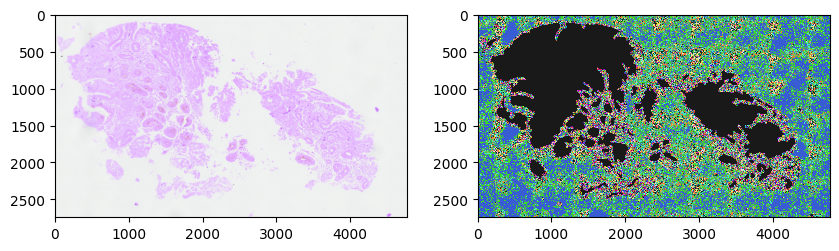

In [ ]:
vals = np.random.rand(256,3)
vals[0, ...] = [0.9, 0.9, 0.9]
cMap = ListedColormap(1 - vals)

f, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(aux)
#ax[1].imshow(labeled, cmap=cMap) # all tissue regions
ax[1].imshow(mask, cmap=cMap) # largest tissue region
plt.show()



In [ ]:
imagen_binaria_enteros = np.uint8(mask) * 255

In [ ]:
aux2 = cv2.resize(imagen_binaria_enteros, (y*4, x*4))
print(aux2.shape, imagen_binaria_enteros.shape)

(10972, 19084) (2743, 4771)


In [ ]:
imagen_sin_ruido = cv2.medianBlur(aux2, 5)

kernel = np.ones((9, 9), np.uint8)

dilatada = cv2.dilate(imagen_sin_ruido, kernel, iterations=1)

erosionada = cv2.erode(dilatada, kernel, iterations=3)

aux2 = cv2.bitwise_not(erosionada)
cv2_imshow(aux2)
cv2.imwrite('imagen_binaria.png', aux2)

## Preprocesamiento

In [5]:
import cv2
import numpy as np
import pandas as pd

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:

def dividir_imagen_en_parches(imagen, patch_size):
    alto, ancho = imagen.shape[:2]
    patch_alto = patch_size
    patch_ancho = patch_size

    # Calcula el número de parches en filas y columnas
    num_parches_filas = (alto + patch_alto - 1) // patch_alto
    num_parches_columnas = (ancho + patch_ancho - 1) // patch_ancho

    parches = []
    size_parches = []
    for i in range(num_parches_filas):
        for j in range(num_parches_columnas):
            # Calcula las coordenadas de inicio y fin del parche
            y_start = i * patch_alto
            y_end = min((i + 1) * patch_alto, alto)
            x_start = j * patch_ancho
            x_end = min((j + 1) * patch_ancho, ancho)

            # Extrae el parche de la imagen
            patch = imagen[y_start:y_end, x_start:x_end]
            size_parches.append(patch.shape[:2])

            # Si el parche no tiene el tamaño deseado, lo completa con píxeles blancos
            if patch.shape[:2] != patch_size:
                patch_completo = np.ones((patch_size, patch_size, 3), dtype=np.uint8) * 255
                patch_completo[:patch.shape[0], :patch.shape[1]] = patch
                patch = patch_completo

            # Agrega el parche a la lista de parches
            parches.append(patch)

    return parches,size_parches

# Ejemplo de uso
imagen_original = cv2.imread('/content/drive/MyDrive/Mauricio Caviedes/AlcianBlue/001_008_2019_ab.jpg')
parches,size_parches = dividir_imagen_en_parches(imagen_original, 1024)

df1 = pd.DataFrame(columns=['Nombre', 'Alto', 'Ancho'])

for i, parche in enumerate(parches):
    nombre_parche = f'parche_{i}'
    df1.loc[len(df1)] = {'Nombre': nombre_parche, 'Alto': size_parches[i][0], 'Ancho': size_parches[i][1]}
    df1.to_csv('data_file_original.csv', index=False)

# Guardar los parches como imágenes individuales
for i, parche in enumerate(parches):
    cv2.imwrite(f'/content/drive/MyDrive/Mauricio Caviedes/AlcianBlue/image/001_008_2019_ab/parche_{i}.png', parche)


In [8]:
import os

# Carpeta de la que quieres obtener la lista de archivos
directorio = '/content/drive/MyDrive/Mauricio Caviedes/AlcianBlue/image/001_008_2019_ab'

# Lista para almacenar las rutas absolutas de los archivos
rutas_archivos = []

# Obtener la lista de archivos en el directorio
archivos = os.listdir(directorio)

# Iterar sobre los archivos y obtener las rutas absolutas
for archivo in archivos:
    ruta_absoluta = os.path.abspath(os.path.join(directorio, archivo))
    rutas_archivos.append(ruta_absoluta)

In [9]:
!pip install histomicstk --find-links https://girder.github.io/large_image_wheels

Looking in links: https://girder.github.io/large_image_wheels
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 645.0/645.0 kB 9.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 47.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 MB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.1/98.1 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.4/94.4 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.5/42.5 MB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.4/225.4 kB 26.7 MB/s eta 0:00:00
     ━

In [10]:
import cv2
import numpy as np

import girder_client
import numpy as np
from skimage.transform import resize
from matplotlib import pylab as plt
from matplotlib.colors import ListedColormap
from histomicstk.preprocessing.color_normalization import reinhard
from histomicstk.saliency.tissue_detection import (
    get_slide_thumbnail, get_tissue_mask)
from histomicstk.annotations_and_masks.annotation_and_mask_utils import (
    get_image_from_htk_response)
from histomicstk.preprocessing.color_normalization.\
    deconvolution_based_normalization import deconvolution_based_normalization
from histomicstk.preprocessing.color_deconvolution.\
    color_deconvolution import color_deconvolution_routine, stain_unmixing_routine
from histomicstk.preprocessing.augmentation.\
    color_augmentation import rgb_perturb_stain_concentration, perturb_stain_concentration


def normalization_r(image):

  # Cargar la imagen en formato JPG
  #imagen_png = cv2.imread(image)
  imagen_png = image


  # color norm. standard (from TCGA-A2-A3XS-DX1, Amgad et al, 2019)
  cnorm = {
      'mu': np.array([8.74108109, -0.12440419,  0.0444982]),
      'sigma': np.array([0.6135447, 0.10989545, 0.0286032]),
  }

  # TCGA-A2-A3XS-DX1_xmin21421_ymin37486_.png, Amgad et al, 2019)
  # for macenco (obtained using rgb_separate_stains_macenko_pca()
  # and reordered such that columns are the order:
  # Hamtoxylin, Eosin, Null
  W_target = np.array([
      [0.5807549,  0.08314027,  0.08213795],
      [0.71681094,  0.90081588,  0.41999816],
      [0.38588316,  0.42616716, -0.90380025],
  ])


  tissue_rgb_normalized = reinhard(imagen_png, target_mu=cnorm['mu'], target_sigma=cnorm['sigma'])

  return tissue_rgb_normalized


In [11]:
name = []
patient = []
grade_1 = []
grade_2 = []
fold = []
height = []
width = []
img_npy = []
anno_npy = []

for i in range(len(rutas_archivos)):
  name.append(str(i))
  patient.append("patient_"+str(i))
  grade_1.append("metaplasia")
  grade_2.append("metaplasia")
  fold.append(3)
  height.append(512)
  width.append(512)

  aux = rutas_archivos[i]
  aux = aux.split("/")
  aux = aux[-1]
  aux2 = aux
  aux = aux.split(".")
  aux = aux[0]
  img = cv2.imread(rutas_archivos[i])
  img = cv2.resize(img, (512, 512), interpolation = cv2.INTER_LINEAR)
  img = normalization_r(img)
  np.save("/content/drive/MyDrive/Mauricio Caviedes/AlcianBlue/npy/001_008_2019_ab/"+aux, img)
  img_npy.append("/content/drive/MyDrive/Mauricio Caviedes/AlcianBlue/npy/001_008_2019_ab/"+str(aux)+".npy")
  anno_npy.append("/content/drive/MyDrive/Mauricio Caviedes/AlcianBlue/npy/001_008_2019_ab/"+str(aux)+".npy")



In [12]:
df = pd.DataFrame(columns=['name','patient ID','grade (GlaS)','grade (Sirinukunwattana et al. 2015)','fold','image_height','image_width', 'img_npy', 'anno_npy'])
df['name'] = name
df['patient ID'] = patient
df['grade (GlaS)'] = grade_1
df['grade (Sirinukunwattana et al. 2015)'] = grade_2
df['fold'] = fold
df['image_height'] = height
df['image_width'] = width
df['img_npy'] = img_npy
df['anno_npy'] = anno_npy

df.to_csv('data.csv', index=False)

## Reconstruir imagen

In [1]:
import pandas as pd
import cv2
import os
import numpy as np

def cargar_datos(data_file):
    # Cargar el archivo CSV
    df = pd.read_csv(data_file)
    return df

def reconstruir_imagen(parches_dir, df, imagen_original):
    # Crear una imagen vacía del tamaño original
    imagen_reconstruida =  np.zeros(imagen_original.shape)

    # Iterar sobre cada fila del dataframe
    for index, row in df.iterrows():
        nombre_parche = row['Nombre']
        alto_parche = row['Alto']
        ancho_parche = row['Ancho']

        # Leer el parche de imagen
        parche_path = os.path.join(parches_dir, nombre_parche)
        parche_path = parche_path+".png"
        parche = cv2.imread(parche_path)
        parche = cv2.resize(parche, (1024, 1024), interpolation = cv2.INTER_LINEAR)

        # Recortar el parche si es necesario
        if parche.shape[:2] != (alto_parche, ancho_parche):
            parche = parche[:alto_parche, :ancho_parche]

        cv2.imwrite(f'/content/drive/MyDrive/Mauricio Caviedes/AlcianBlue/mask_modif/001_008_2019_ab/{nombre_parche}.png', parche)

# Rutas de los archivos y directorios
data_file = 'data_file_original.csv'
parches_dir = '/content/drive/MyDrive/Mauricio Caviedes/AlcianBlue/mask/001_008_2019_ab/'
imagen_original_path = '/content/drive/MyDrive/Mauricio Caviedes/AlcianBlue/001_008_2019_ab.jpg'

# Cargar los datos del archivo CSV
df = cargar_datos(data_file)

# Leer la imagen original
imagen_original = cv2.imread(imagen_original_path)

# Obtener las dimensiones originales de la imagen
alto_original, ancho_original = imagen_original.shape[:2]

reconstruir_imagen(parches_dir, df, imagen_original)

# Mostrar la imagen reconstruida


In [2]:
import pandas as pd
import cv2
import os
import numpy as np

def unir_parches(parches, forma_original):
    alto, ancho = forma_original[:2]
    imagen_reconstruida = np.zeros((alto, ancho,3), dtype=np.uint8)
    index = 0

    # Iterar sobre la imagen reconstruyendo los parches
    for y in range(0, alto, tamaño_parche):
        for x in range(0, ancho, tamaño_parche):
            imagen_reconstruida[y:y+tamaño_parche, x:x+tamaño_parche] = parches[index]
            index += 1

    return imagen_reconstruida


imagen_original = cv2.imread('/content/drive/MyDrive/Mauricio Caviedes/AlcianBlue/001_008_2019_ab.jpg')

# Tamaño de los parches
tamaño_parche = 1024

parches = []
# Directorio que contiene las imágenes
directorio = '/content/drive/MyDrive/Mauricio Caviedes/AlcianBlue/mask_modif/001_008_2019_ab/'

# Obtener la lista de archivos en el directorio
archivos = os.listdir(directorio)

# Iterar sobre los archivos y cargar las imágenes
for archivo in archivos:
    ruta_absoluta = os.path.join(directorio, archivo)
    if os.path.isfile(ruta_absoluta) and archivo.endswith(('.png')):
        imagen = cv2.imread(ruta_absoluta)
        if imagen is not None:
            parches.append(imagen)

# Mostrar la cantidad de imágenes cargadas
print("Se cargaron", len(parches), "imágenes.")

# Unir los parches para reconstruir la imagen original
imagen_reconstruida = unir_parches(parches, imagen_original.shape)
cv2.imwrite('imagen_reconstruida.jpg', imagen_reconstruida)

Se cargaron 209 imágenes.


True